In [1]:
import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import integrate 
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [4]:
mp_key = "23hOiKlEoGQW353WjxM4GcQtg20eKzYt"
mp_id = "mp-10969"

In [5]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

MPRestError: HTTPConnectionPool(host='api.materialsproject.org', port=80): Max retries exceeded with url: /materials/summary/?material_ids=mp-10969&_fields=structure&_per_page=1000&_page=1 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9b5de13760>: Failed to establish a new connection: [Errno 110] Connection timed out'))

In [10]:
temperatures = np.arange(1,1000,5)
R = 8.314
nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R) #mesures expérimentales

In [18]:
# Modèle d'Einstein
def cv_Einstein(T, Te): # cv/3NatR
    return (Te/T)**2*np.exp(Te/T) / (np.exp(Te/T)-1)**2  #prédiction

def error_Einstein(Te):
    cv_E = cv_Einstein(temperatures, Te)  
    return np.sum((ph_cv - cv_E)**2)

Te_init = 200
Te_optimal = minimize(error_Einstein, Te_init).x[0]
print("La température d'Einstein qui minimise l'erreur au sens des moindres carrés est de", str(Te_optimal), "K")


La température d'Einstein qui minimise l'erreur au sens des moindres carrés est de 221.75614281778428 K


In [12]:
# Modèle de Debye
def integrande(x):
    return (x**4*np.exp(x)) / (np.exp(x)-1)**2

def cv_Debye(T, Td):
    return 3*(T/Td)**3 * integrate.quad(integrande,0,Td/T)[0]

def error_Debye(theta_D):
    return np.sum([(cv_Debye(temperatures[i], theta_D) - ph_cv[i])**2 for i in range(len(temperatures))])

Td_init = 200
Td_optimal = minimize(error_Debye, Td_init).x[0]

print("La température de Debye qui minimise l'erreur au sens des moindres carrés est de", str(Td_optimal), "K")

La température de Debye qui minimise l'erreur au sens des moindres carrés est de 300.1239875620592 K


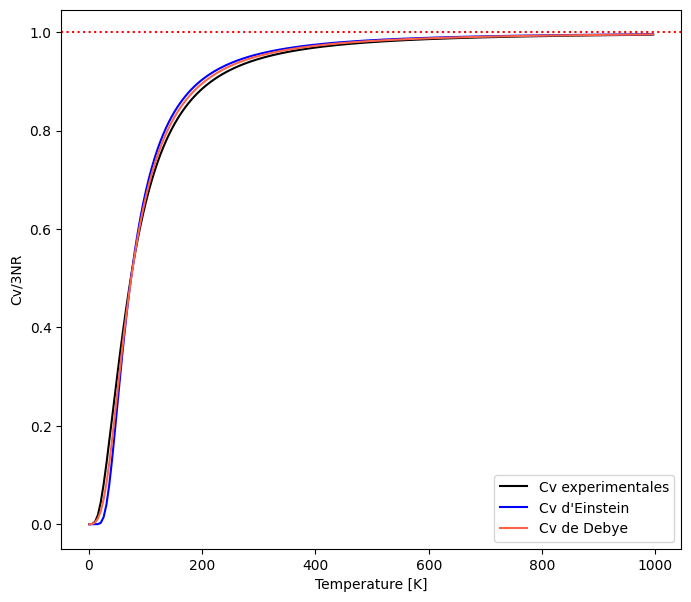

In [13]:
cv_E = cv_Einstein(temperatures, Te_optimal)
cv_D = np.array([cv_Debye(temp, Td_optimal) for temp in temperatures])

plt.figure(figsize=(8, 7))
plt.plot(temperatures, ph_cv, label="Cv experimentales", color='black')
plt.plot(temperatures, cv_E, label="Cv d'Einstein" , color='blue')
plt.plot(temperatures, cv_D, label="Cv de Debye", color='tomato')
plt.axhline(y=1, color='red', linestyle= 'dotted')
plt.xlabel('Temperature [K]')
plt.ylabel("Cv/3NR")
plt.legend()
plt.show()

In [14]:
frequencies = ph_dos.frequencies
densities = ph_dos.densities

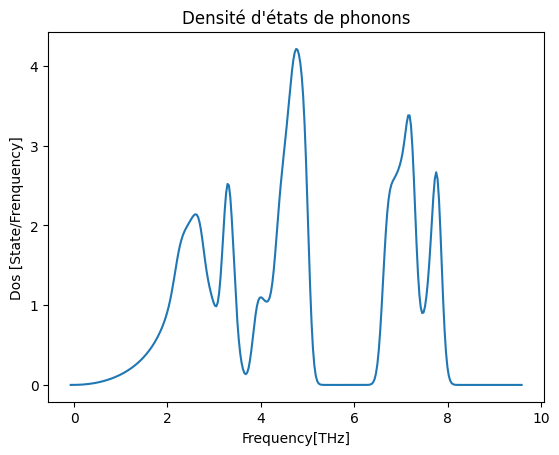

In [15]:
# Plot de la densité d'états des phonons 
plt.plot(frequencies, densities)
plt.xlabel('Frequency[THz]')
plt.ylabel('Dos [State/Frenquency]')
plt.title('Densité d\'états de phonons')
plt.show()

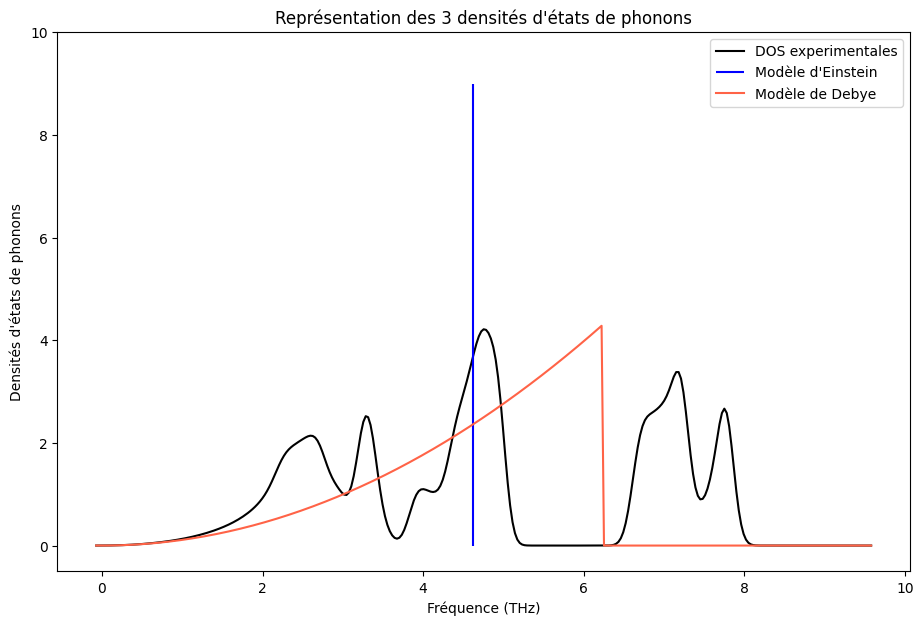

In [26]:
kB = 1.3806485e-23 # J/K : Constante de Boltzmann
hbar = 1.055e-34 # J.s  : Constante de Planck
THz = 1e-12

w_E = Te_optimal * kB * THz / hbar
w_D = Td_optimal * kB * THz / hbar  

dos_D = np.zeros(len(frequencies))
for i,f in enumerate(frequencies):
    w = 2*np.pi*f
    if w < w_D:
        dos_D[i] = (9*nat*(w)**2/(w_D**3))

plt.figure(figsize=(11, 7))
plt.plot(frequencies, densities ,color = "black", label="DOS experimentales")
plt.vlines(w_E/(2*np.pi), 0, 3 * nat ,color ="blue", label = "Modèle d'Einstein") 
plt.plot(frequencies, dos_D*(2*np.pi), color="tomato", label="Modèle de Debye")
plt.title("Représentation des 3 densités d'états de phonons")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence (THz)")
plt.ylim(-0.5, 10)
plt.legend()
plt.show()

On remarque que la fréquence pour Einstein ne varie pas sur le graphique. Cela est normal le modèle d'Einstein fait l'hypothèse que toutes les fréquences sont égales à une fréquence naturelle.